<a href="https://colab.research.google.com/github/dooooing/2023_ESAA/blob/main/1222_%EC%A0%9C%EC%B6%9C__%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_ch4_5_pg_229~240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 07. 이미지 분할(Segmentation)



---


**이미지 분할** 또는 **세그먼테이션** : 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것. 모든 픽셀은 어떤 클래스에 속한다.

모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋을 가지고, 딥러닝 모델을 훈련시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체를 분리할 수 있다

* 의미 분할과 인스턴스 분할로 구분된다
  + 의미 분할 : 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분하는 개념
  + 인스턴스 분할 : 같은 범주에 속하더라도 서로 다른 객체를 구분하는 개념

### 7-1 데이터셋 준비

Oxford-IIIT Pet Dataset 데이터셋 : 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성. 마스크는 각 픽셀에 대한 범주 레이블을 나타낸다

* 영상 처리를 위한 OpenCV를 비롯한 필수 라이브러리 불러오기

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

* 모델 학습에 필요한 입력 이미지의 크기와 학습 파라미터 설정

In [ ]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

* 옥스포드 반려동물 데이터 불러오기
  + 메타 정보 가져와서 info 변수에 저장

In [ ]:
# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete20ZQM8/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete20ZQM8/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


* 원본 이미지와 분할 마스크를 전처리하는 함수 정의
  + 이미지 크기를 사전에 정의한 (128, 128) 크기로 변경하고 자료형 변환
  + 원본 이미지의 픽셀을 255로 나눠서 0-1 범위로 정규화
  + 마스크는 0,1,2의 정수형 값을 갖도록 1을 차감

In [ ]:
# 이미지 전처리 함수
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'],(img_w, img_h))
  img = tf.cast(img, tf.float32) / 255.0
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'],(img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

* 전처리 함수를 훈련 셋, 테스트 셋에 매핑해 주고 미니배치로 분할

In [ ]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


* 샘플 배치를 한 개 선택

In [ ]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

* 배치에서 첫 번째 이미지 출력
  + 255 곱해서 정규화 이전의 원래 값으로 복원

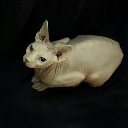

In [ ]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

* 마스크 이미지 출력
  + 마스크 값의 범위는 0-2이므로 2로 나눈 다음에 255 곱해 RGB 이미지로 표현

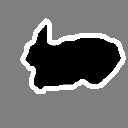

In [ ]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

### 7-2 U-Net 모델(인코더-디코더)



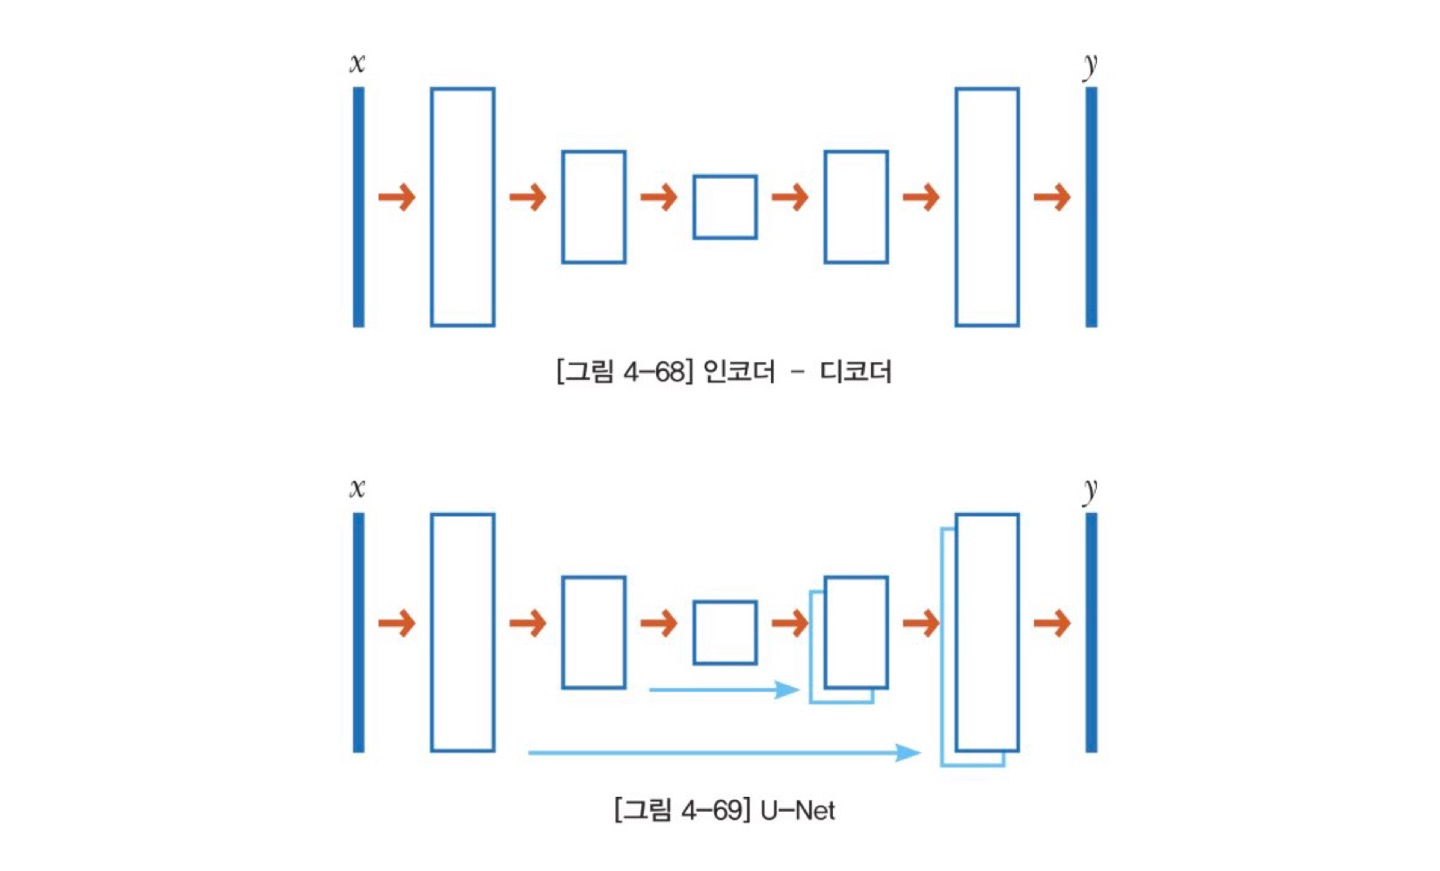

* 사전 학습된 VGG16 모델을 인코더로 활용하는 **U-Net 모델**
  + 사실 사전 학습된 모델 없이 U-Net을 구성하여 학습을 진행해도 학습은 된다. 단, 데이터 개수가 충분하고 시간이 충분하다는 전제에서.

* VGG16 모델을 최종 레이어를 제외한 채로 불러온다

In [ ]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


* VGG16 모델은 합성곱 층과 풀링 층을 직렬로 연결한 구조를 갖는다
  + (128,128) 크기의 텐서가 마지막 레이어에서는 (4,4) 크기로 축소되는 것 확인
  + 이 모델을 U-Net의 인코더로 사용할 예정
  + 인코더는 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소
  + 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0,1,2 중에서 하나로 분류하는 역할

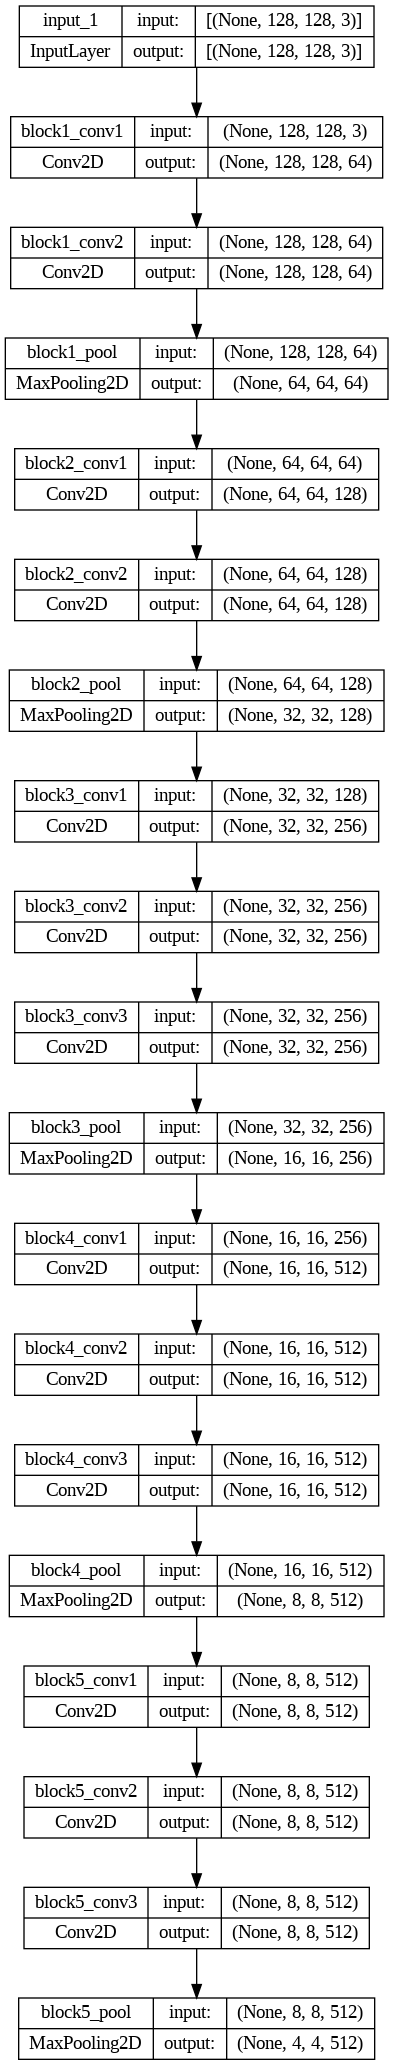

In [ ]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

* 만들고자 하는 U-net의 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 먼저 정한다
  + VGG 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여, 다양한 피처(특징)를 추출하는 인코더 모델 정의

In [ ]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                                  base_model.get_layer(name='block5_conv3').output,
                                  base_model.get_layer(name='block4_conv3').output,
                                  base_model.get_layer(name='block3_conv3').output,
                                  base_model.get_layer(name='block2_conv2').output,
                                  base_model.get_layer(name='block1_conv2').output,
                         ])

* 사전 학습된 파라미터를 인코더에 그대로 사용하기 위해서 업데이트되지 않도록 고정

In [ ]:
# 파라미터 고정
f_model.trainable = False

* 인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달하면서 업샘플링(Up-Sampling)한다
  + 업샘플링 : 축소된 이미지를 원래 이미지 크기로 복원하는 과정

In [ ]:
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

* U-Net 모델 시각화
  + 인코더의 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐지는 것 확인

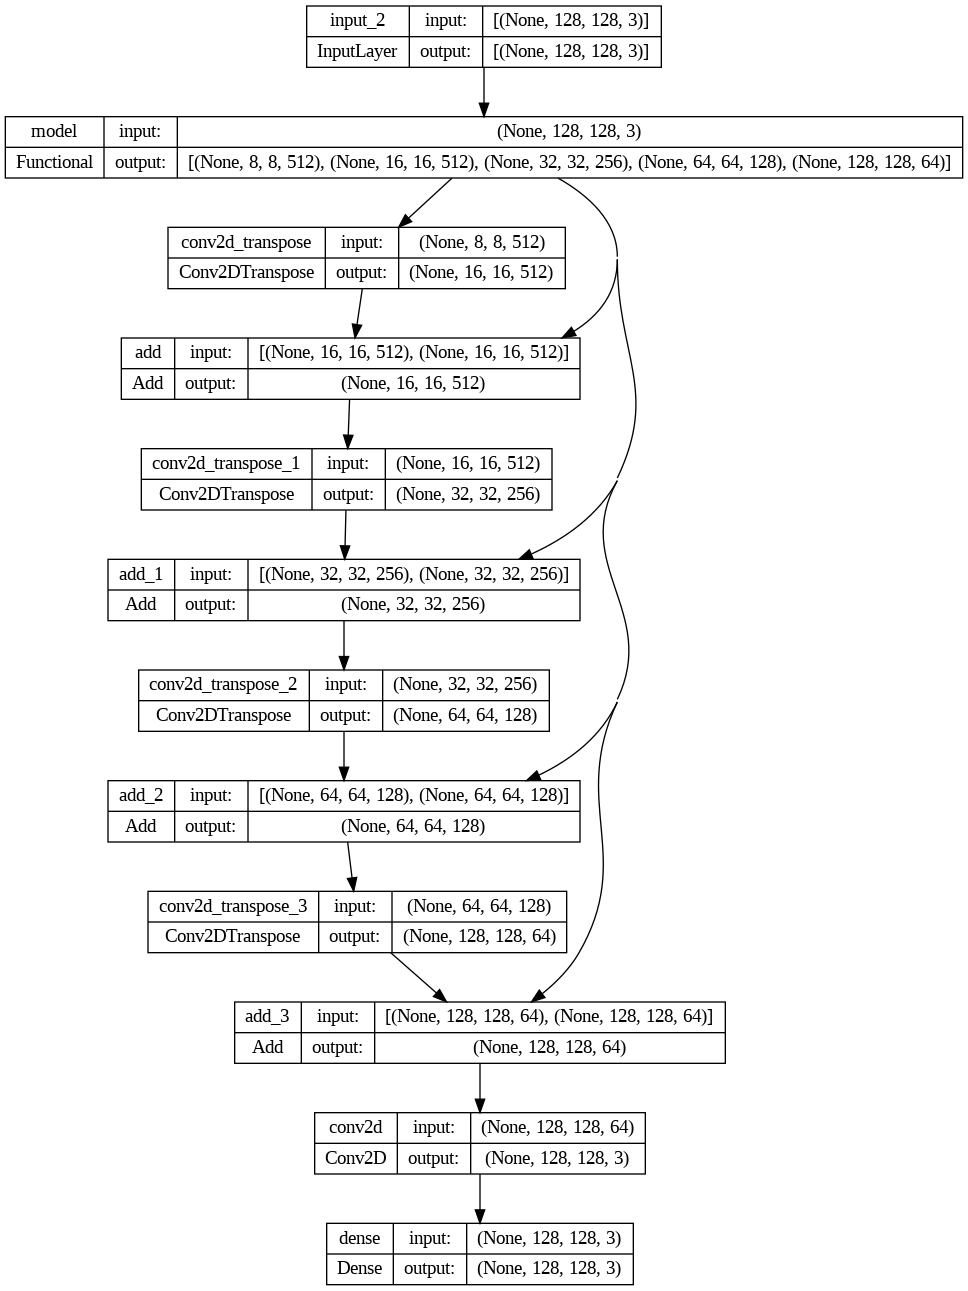

In [ ]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

* 모델 구조 요약
  + 인코더 출력에 사용하기 위해 f_model로부터 유래하는 5개 레이어의 14714688개의 파라미터는 학습되지 않도록 고정

In [ ]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_2[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

* 예측 클래스 개수가 3개인 다중 분류 문제
  + SparseCategoricalCrossentropy 손실함수 설정
  + Adam 옵티마이저 적용

In [ ]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 37s 75ms/step - loss: 0.8674 - accuracy: 0.6848
Epoch 2/5
230/230 [==============================] - 21s 77ms/step - loss: 0.5080 - accuracy: 0.8149
Epoch 3/5
230/230 [==============================] - 20s 77ms/step - loss: 0.4524 - accuracy: 0.8344
Epoch 4/5
230/230 [==============================] - 21s 81ms/step - loss: 0.4270 - accuracy: 0.8427
Epoch 5/5
230/230 [==============================] - 21s 79ms/step - loss: 0.4145 - accuracy: 0.8462


* 검증 셋의 배치를 하나 선택하고 predict() 메소드로 이미지 분할 클래스 예측

1/1 [==============================] - 0s 350ms/step


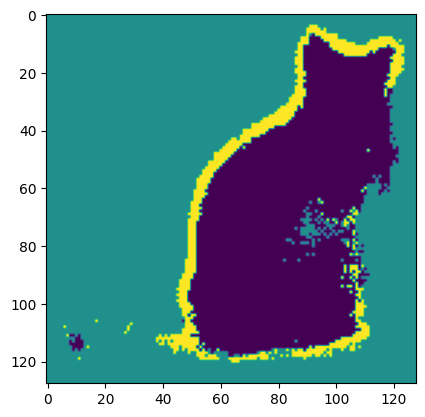

In [ ]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

* 정답 마스크 이미지를 출력하고, 앞서 예측한 분할 이미지와 비교

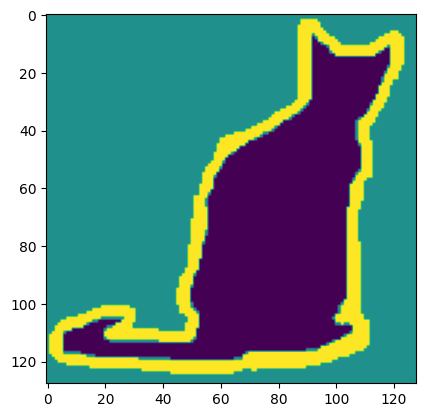

In [ ]:
# 첫 번쨰 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128)))